# Project 04 (ELITE): Entropy-Optimizer - Neural Network from Scratch

**Author:** Davi Bonetto  
**Course Module:** 01-Janeiro-Math  

## 1. Synthesis: The Ghost in the Machine

This project is the culmination of our January module. We fuse the three pillars we've constructed:

1.  **Matrices (Project 01):** The engine of our Forward Pass.
2.  **Optimization (Project 02):** The Gradient Descent mechanism of our Backward Pass.
3.  **Entropy (Project 03):** The Loss Function (Cross-Entropy) guiding our learning.

We will build a **Neural Network from scratch** (using only NumPy) to solve a non-linear classification problem.

**The Elite Differential:** We implement **Weight Decay (L2 Regularization)** manually in the backpropagation loop, demonstrating how we enforce the *Minimum Description Length* principle to prevent overfitting.

## 2. Data Generation: The Non-Linear Challenge

Linearly separable data (like AND/OR gates) is trivial. We generate "Moons"—two interleaving half-circles that a simple linear classifier cannot solve.

X shape: (500, 2)
y shape: (500, 1)


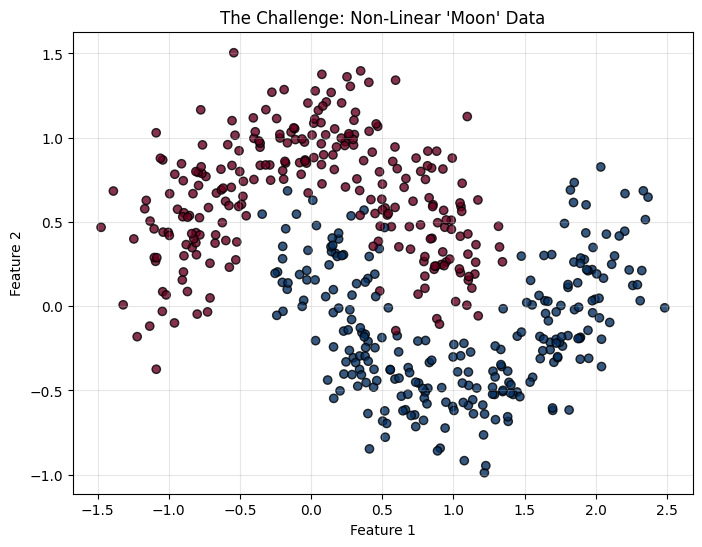

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

# 1. Generate Data
X, y = make_moons(n_samples=500, noise=0.2, random_state=42)
# Reshape y to be (m, 1) for proper matrix ops
y = y.reshape(-1, 1)

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

# 2. Visualize
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y.ravel(), cmap='RdBu', edgecolors='k', alpha=0.8)
plt.title("The Challenge: Non-Linear 'Moon' Data")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.grid(True, alpha=0.3)
plt.show()

## 3. The 'NeuralNet' Class

We implement a 2-Layer Perceptron:
- **Input:** 2 Features.
- **Hidden:** 10 Neurons (ReLU).
- **Output:** 1 Neuron (Sigmoid).

### 3.1 Mathematical Definitions
**Forward:**
$$ Z^{[1]} = X \cdot W^{[1]} + b^{[1]} $$
$$ A^{[1]} = \text{ReLU}(Z^{[1]}) $$
$$ Z^{[2]} = A^{[1]} \cdot W^{[2]} + b^{[2]} $$
$$ A^{[2]} = \sigma(Z^{[2]}) $$

**Loss (Binary Cross-Entropy):**
$$ \mathcal{L} = - \frac{1}{m} \sum \left( y \log(A^{[2]}) + (1-y) \log(1-A^{[2]}) \right) $$

In [2]:
class NeuralNetwork:
    def __init__(self, input_size=2, hidden_size=10, output_size=1):
        # He Initialization for ReLU layers (good practice)
        self.W1 = np.random.randn(input_size, hidden_size) * np.sqrt(2. / input_size)
        self.b1 = np.zeros((1, hidden_size))

        # Xavier/Glorot for Sigmoid output
        self.W2 = np.random.randn(hidden_size, output_size) * np.sqrt(1. / hidden_size)
        self.b2 = np.zeros((1, output_size))

    def relu(self, Z):
        return np.maximum(0, Z)

    def sigmoid(self, Z):
        return 1 / (1 + np.exp(-Z))

    def forward(self, X):
        self.Z1 = np.dot(X, self.W1) + self.b1
        self.A1 = self.relu(self.Z1)

        self.Z2 = np.dot(self.A1, self.W2) + self.b2
        self.A2 = self.sigmoid(self.Z2)
        return self.A2

    def compute_loss(self, A2, Y, lambd=0):
        m = Y.shape[0]
        # Cross Entropy
        logprobs = np.multiply(Y, np.log(A2 + 1e-15)) + np.multiply((1 - Y), np.log(1 - A2 + 1e-15))
        base_loss = -np.sum(logprobs) / m

        # L2 Regularization term: (lambda / 2m) * sum(W^2)
        L2_cost = (lambd / (2 * m)) * (np.sum(np.square(self.W1)) + np.sum(np.square(self.W2)))

        return base_loss + L2_cost

    def backward(self, X, Y, learning_rate=0.01, lambd=0):
        """
        Backpropagation with L2 Regularization (Weight Decay).
        """
        m = X.shape[0]

        # 1. Output Layer Gradient
        dZ2 = self.A2 - Y
        # Add regularization derivative to dW: + (lambda/m) * W
        dW2 = (1 / m) * np.dot(self.A1.T, dZ2) + (lambd / m) * self.W2
        db2 = (1 / m) * np.sum(dZ2, axis=0, keepdims=True)

        # 2. Hidden Layer Gradient
        dA1 = np.dot(dZ2, self.W2.T)
        dZ1 = dA1 * (self.Z1 > 0) # ReLU derivative
        dW1 = (1 / m) * np.dot(X.T, dZ1) + (lambd / m) * self.W1
        db1 = (1 / m) * np.sum(dZ1, axis=0, keepdims=True)

        # 3. Update Parameters
        self.W1 -= learning_rate * dW1
        self.b1 -= learning_rate * db1
        self.W2 -= learning_rate * dW2
        self.b2 -= learning_rate * db2

## 4. The Elite Differential: Information-Based Decay

We applied **Weight Decay** (L2 Regularization $\lambda$) in the backward definition.

**Theory:**
Statistical learning theory tells us that complex models (large weights) generalize poorly. By adding $\frac{\lambda}{2m} ||W||^2$ to our cost, we essentially impose a **Gaussian Prior** on our parameters. We punish the model for trying to "memorize" noise. This forces the network to find the simplest curve that fits the data (Occam's Razor).

In [3]:
# Config
learning_rate = 0.1
epochs = 10000
reg_lambda = 0.05 # Strength of definition penalty

# Initialize
nn = NeuralNetwork(input_size=2, hidden_size=10, output_size=1)
history = []

# Training Loop
print(f"Training Start - LR: {learning_rate}, Lambda: {reg_lambda}")
for i in range(epochs):
    # Forward
    A2 = nn.forward(X)

    # Loss
    cost = nn.compute_loss(A2, y, lambd=reg_lambda)

    # Backward
    nn.backward(X, y, learning_rate, lambd=reg_lambda)

    if i % 1000 == 0:
        history.append(cost)
        print(f"Epoch {i}: Loss = {cost:.5f}")

print(f"Final Loss: {cost:.5f}")

Training Start - LR: 0.1, Lambda: 0.05
Epoch 0: Loss = 0.74192
Epoch 1000: Loss = 0.18435
Epoch 2000: Loss = 0.10030
Epoch 3000: Loss = 0.07562
Epoch 4000: Loss = 0.06649
Epoch 5000: Loss = 0.06204
Epoch 6000: Loss = 0.05926
Epoch 7000: Loss = 0.05745
Epoch 8000: Loss = 0.05620
Epoch 9000: Loss = 0.05528
Final Loss: 0.05459


## 6. Visualization: The Decision Boundary

Finally, we visualize what the network actually "learned". We define a grid of points over the entire feature space and ask the network to classify each pixel. This reveals the non-linear decision boundary.

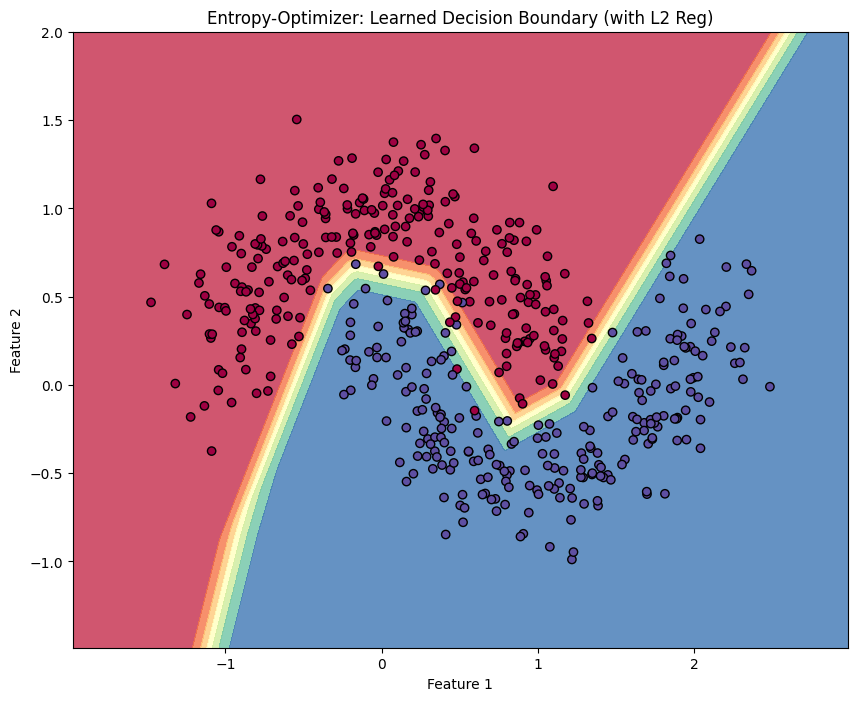

In [4]:
def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    h = 0.01

    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Predict the function value for the whole grid
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    Z = model.forward(grid_points)
    Z = Z.reshape(xx.shape)

    # Plot the contour and training examples
    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y.ravel(), cmap=plt.cm.Spectral, edgecolors='k')
    plt.title("Entropy-Optimizer: Learned Decision Boundary (with L2 Reg)")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.show()

plot_decision_boundary(nn, X, y)

## 7. Conclusion: The Trinity of AI

We have successfully built a "Brain in a Box".

- **Linear Algebra** provided the structure (Matrix dot products).
- **Calculus** provided the correction mechanism (Gradients).
- **Information Theory** provided the goal (Minimize Entropy).

This concludes Module 01. By understanding these components in raw Python/NumPy, we are now truly ready to wield PyTorch in Module 02.